In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score,\
    roc_auc_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import sys, re
from collections import OrderedDict
import seaborn as sns
from sklearn import preprocessing
import _pickle as pickle
from sklearn import tree
from sklearn import svm

In [16]:
seed = 142
pd.options.display.max_columns = 50
np.random.seed(seed)

## Read data

In [17]:
data = pd.read_feather('Xy_norm.feather')

In [18]:
data.shape

(245455, 42)

In [19]:
data.head(3)

,orders_num,is_failed_num,voucher_amount_sum,delivery_fee_mean,delivery_fee_sum,restaurant_id_unq_num,city_id_unq_num,payment_id_unq_num,platform_id_unq_num,transmission_id_unq_num,amount_paid_mean,amount_paid_std,payment_id_1491_num,payment_id_1523_num,payment_id_1619_num,payment_id_1779_num,payment_id_1811_num,platform_id_525_num,platform_id_22167_num,platform_id_22263_num,platform_id_22295_num,platform_id_29463_num,platform_id_29495_num,platform_id_29751_num,platform_id_29815_num,platform_id_30135_num,platform_id_30199_num,platform_id_30231_num,platform_id_30359_num,platform_id_30391_num,platform_id_30423_num,transmission_id_212_num,transmission_id_1988_num,transmission_id_2020_num,transmission_id_4196_num,transmission_id_4228_num,transmission_id_4260_num,transmission_id_4324_num,transmission_id_4356_num,transmission_id_4996_num,transmission_id_21124_num,is_returning_customer
0,-0.313796,-0.153931,-0.160605,-0.534689,-0.248892,-0.412621,-0.170542,-0.3857,-0.407176,-0.515242,0.114188,-0.462233,-0.096045,-0.026364,-0.417414,0.012129,-0.109599,-0.061359,-0.003496,-0.012939,-0.002018,-0.259836,-0.121011,-0.064448,-0.193848,-0.010699,-0.02617,0.029065,-0.256269,-0.172863,-0.105601,-0.095907,-0.025389,-0.002018,-0.067011,-0.295478,-0.114311,-0.330953,-0.100007,-0.103457,-0.021054,0
1,-0.313796,-0.153931,-0.160605,-0.534689,-0.248892,-0.412621,-0.170542,-0.3857,-0.407176,-0.515242,-0.215465,-0.462233,-0.096045,-0.026364,-0.202441,-0.250828,-0.109599,-0.061359,-0.003496,-0.012939,-0.002018,-0.259836,-0.121011,-0.064448,-0.193848,-0.010699,-0.02617,-0.219259,0.350588,-0.172863,-0.105601,-0.095907,-0.025389,-0.002018,-0.067011,-0.295478,-0.114311,-0.330953,-0.100007,-0.103457,-0.021054,0
2,-0.313796,-0.153931,-0.160605,0.864187,-0.037560,-0.412621,-0.170542,-0.3857,-0.407176,-0.515242,-0.839974,-0.462233,-0.096045,-0.026364,-0.202441,-0.250828,-0.109599,-0.061359,-0.003496,-0.012939,-0.002018,-0.259836,-0.121011,-0.064448,-0.193848,-0.010699,-0.02617,-0.219259,0.350588,-0.172863,-0.105601,-0.095907,-0.025389,-0.002018,-0.067011,-0.295478,-0.114311,0.067902,-0.354967,-0.103457,-0.021054,1


In [20]:
X = data.iloc[:, 1:-1]
y = data.iloc[:, -1]

In [21]:
# Create train, val, test matrices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, 
                                                    shuffle=True, random_state=seed) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.1, stratify=y_test, 
                                                shuffle=True, random_state=seed) 

In [22]:
# Check if splitting has the same ratio of positive labels
y_train.mean(), y_val.mean(), y_test.mean(), len(y_train), len(y_val), len(y_test)

(0.22614045094227614,
 0.22614035881882516,
 0.22609994568169473,
 171818,
 66273,
 7364)

$Comment$: Distribution of labels is the same for train, validation and test sets.

## Create metric functions

In [23]:
# Compute metrics: accuracy, auc, aps, precision, recall, f1
def compute_metrics(y_true, y_pred, prob):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, prob)
    aps = average_precision_score(y_true, prob)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {'acc': acc, 'auc': auc, 'aps': aps, 
            'precision': precision, 'recall': recall, 
            'f1': f1}


# Compute basic metrics: accuracy, auc, aps (used for zero baseline mainly)
def compute_basic_metrics(y_true, y_pred, prob):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, prob)
    aps = average_precision_score(y_true, prob)
    
    return {'acc': acc, 'auc': auc, 'aps': aps}


# Compute accuracy for different thresholds [0.1, ..., 0.9]
def try_acc_thresholds(model, data_dict):
    thresholds = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
    for thr in thresholds:
        acc_train = accuracy_score(data_dict['y_train'], 
                                   (model.predict_proba(data_dict['X_train'])[:,1] > thr).astype('int'))
        acc_val = accuracy_score(data_dict['y_val'], 
                                 (model.predict_proba(data_dict['X_val'])[:,1] > thr).astype('int'))
        print('Threshold= {}, Train acc= {:.3f},  Val acc= {:.3f}'.format(thr, acc_train, acc_val))
        
        
# Compute basic metrics for zero output 
def compute_zero_baseline(y_true):
    metric_dict = compute_basic_metrics(y_true, np.zeros(y_true.shape[0]), np.zeros(y_true.shape[0]))
    return metric_dict


# Compute metrics for random 0/1 output 
def compute_rand_baseline(y_true, thr=0.5):
    rand_pred = np.random.random_sample((y_true.shape[0],))
    metric_dict = compute_metrics(y_true, np.round(rand_pred + 0.5 - thr), rand_pred)
    return metric_dict

## Baseline

### Train set

In [24]:
# Zero baseline
compute_zero_baseline(y_train)

{'acc': 0.77385954905772392, 'auc': 0.5, 'aps': 0.22614045094227614}

In [25]:
# Random baseline (threshold=0.5)
compute_rand_baseline(y_train, thr=0.5)

{'acc': 0.50166455202598093,
 'auc': 0.49902688741915818,
 'aps': 0.22540208355054861,
 'precision': 0.22651571856287425,
 'recall': 0.49846866555140906,
 'f1': 0.3114852966009698}

In [26]:
# Random baseline (threshold=0.5)
compute_rand_baseline(y_train, thr=0.9)

{'acc': 0.71883621040868828,
 'auc': 0.49983634918525133,
 'aps': 0.22591723023333327,
 'precision': 0.2247262986256697,
 'recall': 0.09931797709432505,
 'f1': 0.13775501097685044}

### Validation set

In [27]:
# Zero baseline
compute_zero_baseline(y_val)

{'acc': 0.77385964118117478, 'auc': 0.5, 'aps': 0.22614035881882516}

In [28]:
# Random baseline (threshold=0.5)
compute_rand_baseline(y_val, thr=0.5)

{'acc': 0.49979629713457968,
 'auc': 0.49895146944039614,
 'aps': 0.22480537945599074,
 'precision': 0.22617216945575155,
 'recall': 0.5005004337092146,
 'f1': 0.31155507559395246}

In [29]:
# Random baseline (threshold=0.9)
compute_rand_baseline(y_val, thr=0.9)

{'acc': 0.71950869886680846,
 'auc': 0.49780329578931493,
 'aps': 0.22545030671614247,
 'precision': 0.2266241651487553,
 'recall': 0.099619670380996866,
 'f1': 0.13840092699884124}

$Comment$: We will compare these zero and random baselines metrics with the models below.

## Logistic regression

In [30]:
# Train with regularization
log_reg = LogisticRegression(C=1.0)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
# Predict for val set
y_pred_val = log_reg.predict_proba(X_val)[:,1]

In [32]:
# See the coefficients
log_reg.coef_, log_reg.intercept_

(array([[-0.12285088, -0.01030362, -0.00572957, -0.02866086,  0.03796215,
          0.01761493,  0.0884019 ,  0.13637196,  0.20661698, -0.13702989,
          0.23212244, -0.04069597,  0.04032924,  0.14646664,  0.20079719,
          0.04427254, -0.05777088, -0.00105366, -0.01519414,  0.00268847,
          0.09233123,  0.01914287,  0.06276501,  0.11505164, -0.00090941,
         -0.00617146,  0.10355623,  0.19911338, -0.16014418,  0.02205983,
          0.02016334,  0.04578503,  0.01298719, -0.01535417,  0.16437958,
          0.00608195,  0.04054943,  0.21664891,  0.18991323, -0.00990552]]),
 array([-1.3319579]))

In [36]:
# Collect the outputs and labels
prob_train = log_reg.predict_proba(X_train)[:,1]
y_pred_train = log_reg.predict(X_train)
prob_val = log_reg.predict_proba(X_val)[:,1]
y_pred_val = log_reg.predict(X_val)

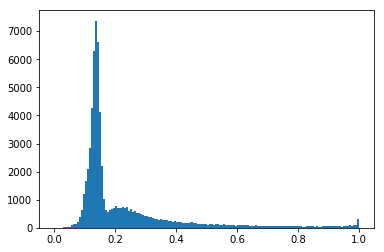

In [37]:
# Check the output distribution (val set)
plt.hist(prob_val, bins=150)
plt.show()

In [43]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.80886752261113504,
 'auc': 0.75145655076534978,
 'aps': 0.54329459842311734,
 'precision': 0.7092173913043478,
 'recall': 0.26238579333419121,
 'f1': 0.38305466842006386}

In [38]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.80773467324551473,
 'auc': 0.75378287981653935,
 'aps': 0.5432914675130337,
 'precision': 0.70005346640527533,
 'recall': 0.26209381463935411,
 'f1': 0.38139625206330713}

In [39]:
# Try thresholds on train set
data_dict = {'X_train': X_train, 'y_train': y_train,
             'X_val': X_val, 'y_val': y_val}
try_acc_thresholds(log_reg, data_dict)

Threshold= 0.1, Train acc= 0.260,  Val acc= 0.260
Threshold= 0.2, Train acc= 0.737,  Val acc= 0.736
Threshold= 0.3, Train acc= 0.794,  Val acc= 0.793
Threshold= 0.4, Train acc= 0.808,  Val acc= 0.807
Threshold= 0.5, Train acc= 0.809,  Val acc= 0.808
Threshold= 0.6, Train acc= 0.805,  Val acc= 0.804
Threshold= 0.7, Train acc= 0.799,  Val acc= 0.799
Threshold= 0.8, Train acc= 0.794,  Val acc= 0.794
Threshold= 0.9, Train acc= 0.788,  Val acc= 0.787


$Comment$: No overfitting as metrics on the validation set are not worse than on the train set.

Threshold 0.5 should work fine to be picked as it gives the best accuracy on both train and val sets.

The model performs better than zero and random baselines.

## Random forests

In [40]:
# Train
tree_clf = RandomForestClassifier(n_estimators=50, max_depth=4)
tree_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
# Collect the outputs and labels
prob_train = tree_clf.predict_proba(X_train)[:,1]
y_pred_train = tree_clf.predict(X_train)
prob_val = tree_clf.predict_proba(X_val)[:,1]
y_pred_val = tree_clf.predict(X_val)

In [42]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.80716222980130137,
 'auc': 0.75868446728275896,
 'aps': 0.5386024973431971,
 'precision': 0.69934503901895206,
 'recall': 0.25831939261356324,
 'f1': 0.37728118480651041}

In [43]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.80651245605299293,
 'auc': 0.75973274772595301,
 'aps': 0.53824588660841943,
 'precision': 0.69397633560415917,
 'recall': 0.25829051844932277,
 'f1': 0.37646486749331387}

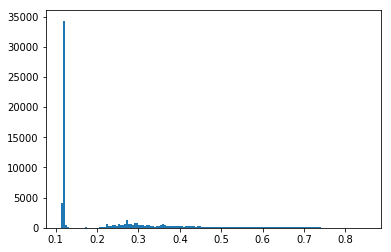

In [44]:
# Check the output distribution (val set)
plt.hist(prob_val, bins=150)
plt.show()

In [45]:
# Try thresholds on train set
try_acc_thresholds(tree_clf, data_dict)

Threshold= 0.1, Train acc= 0.226,  Val acc= 0.226
Threshold= 0.2, Train acc= 0.695,  Val acc= 0.694
Threshold= 0.3, Train acc= 0.775,  Val acc= 0.775
Threshold= 0.4, Train acc= 0.806,  Val acc= 0.805
Threshold= 0.5, Train acc= 0.807,  Val acc= 0.807
Threshold= 0.6, Train acc= 0.798,  Val acc= 0.798
Threshold= 0.7, Train acc= 0.784,  Val acc= 0.784
Threshold= 0.8, Train acc= 0.775,  Val acc= 0.775
Threshold= 0.9, Train acc= 0.774,  Val acc= 0.774


In [46]:
# Train bigger model
tree_clf_2 = RandomForestClassifier(n_estimators=10, max_depth=20)
tree_clf_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
# Collect the outputs and labels
prob_train = tree_clf_2.predict_proba(X_train)[:,1]
y_pred_train = tree_clf_2.predict(X_train)
prob_val = tree_clf_2.predict_proba(X_val)[:,1]
y_pred_val = tree_clf_2.predict(X_val)

In [50]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.87001361906203079,
 'auc': 0.8250329136170953,
 'aps': 0.73713251607246022,
 'precision': 0.93727171669048759,
 'recall': 0.45569424784455026,
 'f1': 0.61323728050427739}

In [51]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.80857966290948047,
 'auc': 0.76187257491895743,
 'aps': 0.53788246887189006,
 'precision': 0.65411922304085734,
 'recall': 0.32581570694601986,
 'f1': 0.43497238553358281}

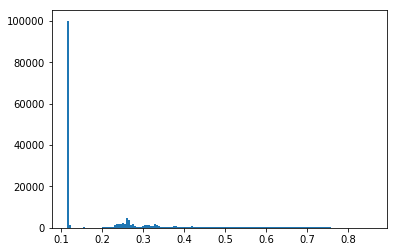

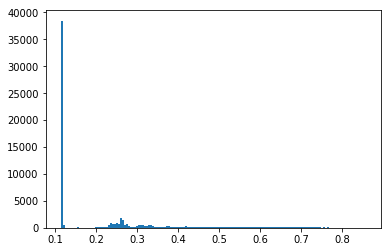

In [103]:
plt.hist(prob_train, bins=150)
plt.show()
plt.hist(prob_val, bins=150)
plt.show()